In [1]:
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import*
from keras.metrics import categorical_crossentropy

import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# GPU Configuration

In [2]:
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [3]:
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at {}'.format(device_name))

Found GPU at /device:GPU:0


In [2]:
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
train_path = '/content/drive/MyDrive/realtime_emotion_detection/train'

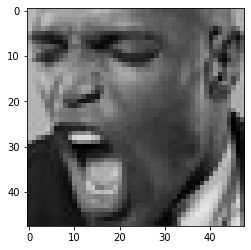

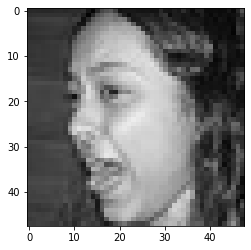

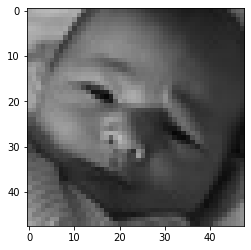

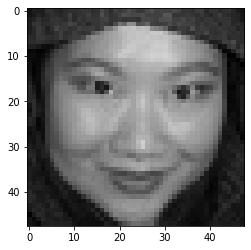

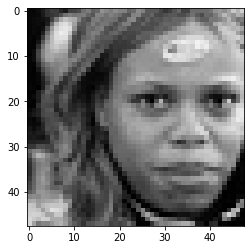

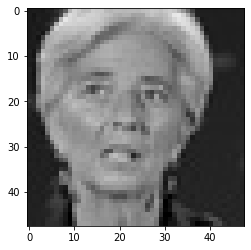

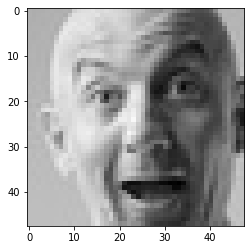

In [4]:
# display the first image in each category
for emo_class in classes:
  path = os.path.join(train_path, emo_class)
  for img in os.listdir(path):
      img_arr = cv2.imread(os.path.join(path, img))
      plt.imshow(cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB))
      plt.show()
      break

    #break

# Pre-processing

Transfer learning allows one to use a pre-trained set of weights for a new purpose/task. The pre-trained weights can be modified for the task at hand - this way the model doesn't need to learn from scratch, rather it has a base of knowledge from which it can build upon.

Since we will be using a pretrained ImageNet model, we know our input must be size 224x224. So we will resize our images.

### convert all images into 224 x 224

In [3]:
train_ds = []
size = 224

for emo_class in classes:
    path = os.path.join(train_path, emo_class)
    for img in os.listdir(path)[:300]:
      try:
        img_arr = cv2.imread(os.path.join(path, img))
        resized_img = cv2.resize(img_arr, (size, size))
        train_ds.append([resized_img, classes.index(emo_class)])
      except Exception as e:
        pass

In [4]:
# shuffle the training data
random.shuffle(train_ds)

### extract features and labels

In [5]:
X = [] # image features
y = [] # labels

for features, label in train_ds:
    X.append(features)
    y.append(label)

# convert X to 4 dimensions (needed for MobileNet)
X = np.array(X).reshape(-1, size, size, 3)

### normalize the data

In [6]:
X = X/255.0 

In [7]:
X.shape

(2094, 224, 224, 3)

In [8]:
len(train_ds)

2094

In [9]:
# convert y list to numpy array
Y = np.array(y)
Y.shape

(2094,)

# Deep Learning Architecture + Transfer Learning

In [69]:
#pre_trained_model = tf.keras.applications.VGG19()
pre_trained_model = tf.keras.applications.MobileNetV2()
pre_trained_model

In [70]:
pre_trained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [14]:
# removing the very last layer from the MobileNet model
base_input = pre_trained_model.layers[0].input
base_output = pre_trained_model.layers[-2].output

base_input, base_output

(<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d')>)

In [26]:
# add custom layers to model
output = layers.Dense(len(classes), activation='relu')(base_output)#layers.Dense(64, activation='relu')(base_output)
#output = layers.Dense(len(classes), activation='relu')(output)
#output = layers.Flatten()(output)
ouput = layers.Dense(len(classes), activation='softmax')(output)

In [27]:
model = keras.Model(
    inputs=base_input,
    outputs=output
)

In [22]:
model = Sequential([
    #Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(224, 224, 3)),
    #MaxPooling2D((2,2)),
    Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dropout(0.4),
    #BatchNormalization(axis=1),
    Dense(len(classes), activation='softmax')
])

In [23]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 32)      18464     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 93312)             0         
                                                                 
 dropout_5 (Dropout)         (None, 93312)            

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    X,
    Y,
    epochs=30,
    batch_size=16,
    verbose=1,
    validation_split=0.2
)

Epoch 1/30
105/105 [==============================] - 4s 39ms/step - loss: 0.1532 - accuracy: 0.9528 - val_loss: 6.8254 - val_accuracy: 0.2530
Epoch 2/30
105/105 [==============================] - 4s 36ms/step - loss: 0.1369 - accuracy: 0.9576 - val_loss: 8.3843 - val_accuracy: 0.2339
Epoch 3/30
105/105 [==============================] - 4s 38ms/step - loss: 0.1651 - accuracy: 0.9546 - val_loss: 7.1737 - val_accuracy: 0.2267
Epoch 4/30
105/105 [==============================] - 4s 36ms/step - loss: 0.1428 - accuracy: 0.9576 - val_loss: 6.8100 - val_accuracy: 0.2339
Epoch 5/30
105/105 [==============================] - 4s 36ms/step - loss: 0.1060 - accuracy: 0.9737 - val_loss: 7.9104 - val_accuracy: 0.2363
Epoch 6/30
105/105 [==============================] - 4s 36ms/step - loss: 0.0885 - accuracy: 0.9773 - val_loss: 8.3663 - val_accuracy: 0.2363
Epoch 7/30
105/105 [==============================] - 4s 36ms/step - loss: 0.0807 - accuracy: 0.9773 - val_loss: 8.6875 - val_accuracy: 0.2267

In [29]:
model.save('/content/drive/MyDrive/realtime_emotion_detection/model_1.h5')

In [30]:
model.save('/content/drive/MyDrive/realtime_emotion_detection/saved_mdl')

# Setting up Live Webcam Demo

In [47]:
# Google Collab setup

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [53]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [49]:
path = '/content/drive/MyDrive/realtime_emotion_detection/haarcascade_frontalface_default.xml'
font_scale = 1.5
font = cv2.FONT_HERSHEY_PLAIN

In [50]:
def run_live_demo():
  
  cap = cv2.VideoCapture(1)
  while True:
      
      if not cap.isOpened():
          #cap = cv2.VideoCapture(1)
          cap = cv2.VideoCapture(display(Image(take_photo())))
      if not cap.isOpened():
          raise IOError('Cannot open webcam')

      ret, frame = cap.read()
      faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
      gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      faces = faceCascade.detectMultiScale(gray, 1.1, 4)
      
      face_roi = ''
      
      for x,y,w,h in faces:
          roi_gray = gray[y:y+h, x:x+w]
          roi_color = frame[y:y+h, x:x+w]
          cv2.rectangle(frame, (x,y), (x+w, y+h), (255, 0, 0), 2)
          faces = faceCascade.detectMultiScale(roi_gray)

          if len(faces) == 0:
              print('Face not detected')
          else:
              for (ex, ey, ew, eh) in faces:
              # cropping for face
                  face_roi = roi_color[ey:ey+eh, ex:ex+ew]
          
      
      # pre-processing steps
      final_image = cv2.resize(face_roi, (224, 224))
      final_image = np.expand_dims(final_image, axis=0)
      final_image = final_image/255

      font_1 = cv2.FONT_HERSHEY_SIMPLEX

      predictions = model.predict(final_image)

      font_scale = 1.5
      font_2 = cv2.FONT_HERSHEY_PLAIN

      # display the prediction
      status = classes[np.argmax(predictions)]
      x1 = 0
      y1 = 0
      w1 = 175
      h1 = 175

      # draw black rectangle
      cv2.rectangle(frame, (x1, x1), (x1+w1, y1+h1), (0,0,0), -1)

      # text
      cv2.putText(frame, status, (x1+int(w1/10), y1 + int(h1/2)), font_1, 0.7, (0,0,255), 2)
      #cv2.putText(frame, status, (100, 150), font, 3, (0,0,255), 2, cv2.LINE_4)
      cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255))

      cv2.imshow('Face Emotion Recognition', frame)

      if cv2.waitKey(2) & 0xFF == ord('q'):
          break
      
  cap.release()
  cv2.destroyAllWindows()

In [52]:
run_live_demo()